## Twitter-Bot Project 

In [1]:
import tweepy #https://github.com/tweepy/tweepy
from tweepy import TweepError 
import requests
import urllib
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
import os
import logging
import csv
import zipfile
import re
import spacy
import string
import math
import random
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 280)  #show at least 280 characters in columns, full tweets
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
from collections import Counter
# nltk.download('wordnet')
# nltk.download('punkt') 
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.display import Image, display
from threading import Thread, Condition
import time


# twitter API credentials on seperate csv file
file = open('keys.csv')
reader = csv.reader(file)
keys_list = list(reader)[0]
consumer_key = keys_list[0]   
consumer_secret = keys_list[1]
access_key = keys_list[2]
access_secret = keys_list[3]


# authorize twitter, initialize tweepy
try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    print("Developer credentials have been accepted.")
    
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.") 
    logging.warning(e)


Developer credentials have been accepted.


## Build the Dataset

In [2]:
# need to loop if scale exceeds 200 followers 
user_name = api.auth.get_username()

def follower_id_df(user_name):
    """parameter: twitter user_name
       return: a dataframe object with a follower_id column"""
    followers = api.followers(user_name, count=200)  #don't keep calling api
    id_list = [follower.id for follower in followers]
    return pd.DataFrame(id_list, columns=["follower_id"])

dataset_df = follower_id_df(user_name)
print("Current number of users following the bot: ", len(dataset_df["follower_id"]))
dataset_df.tail()

Current number of users following the bot:  79


,follower_id
74,135225426
75,4693615681
76,839166351520325633
77,838444866883452929
78,976724939184144384


In [3]:
# get some tweets from my sheep

def get_column_of_tweets(follower_id_ser, num_tweets):
    """follower_id_ser: is a series containing follower ids
       num_tweets: is the number of tweets to grab per each user id 
       return: a list containing lists of num_tweets tweets for each follower_id"""
    tweets_col = []
    for id in follower_id_ser:
        try:
            tweets = [api.user_timeline(user_id=id, count=num_tweets)]
        except tweepy.TweepError:
            tweets = [tweets_col[0]]
            print("Failed to run the command on that user, Skipping...")
        tweets_col += tweets
    return tweets_col
    
    
def tweets_to_text(tweets_list):
    """paramater: list containing x tweets
       return: list containing the text portion of the tweets in tweets_list"""
    return [tweet.text for tweet in tweets_list]
    
    

dataset_df["tweets"] = get_column_of_tweets(dataset_df["follower_id"], 20)
dataset_df["tweet_text"] = dataset_df["tweets"].apply(tweets_to_text)
dataset_df.tail()

Failed to run the command on that user, Skipping...


,follower_id,tweets,tweet_text
74,135225426,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Sat Jun 20 13:27:32 +0000 2020', 'id': 1274333061606408192, 'id_str': '1274333061606408192', 'text': ""@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper c...","[@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper comes to mind., @DanceOfJesus1 https://t.co/vTU7cPSvbr, RT @Allisonisanerd: The movie villain The actual villain https://t.co/tER901cX25, RT @TheFinestCC: Check out the new @..."
75,4693615681,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Aug 12 15:59:22 +0000 2019', 'id': 1160943871620026368, 'id_str': '1160943871620026368', 'text': 'Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solu...","[Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solution for caulking w… https://t.co/fn2TR3pX1v, Get the best #pool tile and #groutrepair services to restore your surfaces just like new. D’Sapone experts use pate… https://t.co/xu0..."
76,839166351520325633,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Jan 07 01:20:04 +0000 2019', 'id': 1082084418888630274, 'id_str': '1082084418888630274', 'text': 'Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a f...","[Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a fun wild side too.… https://t.co/GWbb2AwNdr, When you decide to not let something slide you pave a way for the women after you to follow in your footsteps. 👣💪🏿C… https://t.co/4ODxF..."
77,838444866883452929,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Oct 22 01:57:29 +0000 2019', 'id': 1186461541425655809, 'id_str': '1186461541425655809', 'text': 'RT @DamianAbella13: Muerde? No ! Pero te juzga ...",[RT @DamianAbella13: Muerde? No ! Pero te juzga https://t.co/MJSewmWnSp]
78,976724939184144384,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Aug 13 11:31:31 +0000 2019', 'id': 1161238849424625664, 'id_str': '1161238849424625664', 'text': '@8T3 With Idencard app we redefined the traditional paper business card to become a smart and di...","[@8T3 With Idencard app we redefined the traditional paper business card to become a smart and digital business card… https://t.co/j5rmDf5Uv6, Hello folks! Here's a complete guide to creating your own digital business card using @IdencardApp \n\n#digitization… https://t.co/tD..."


## Vader Sentiment Analysis

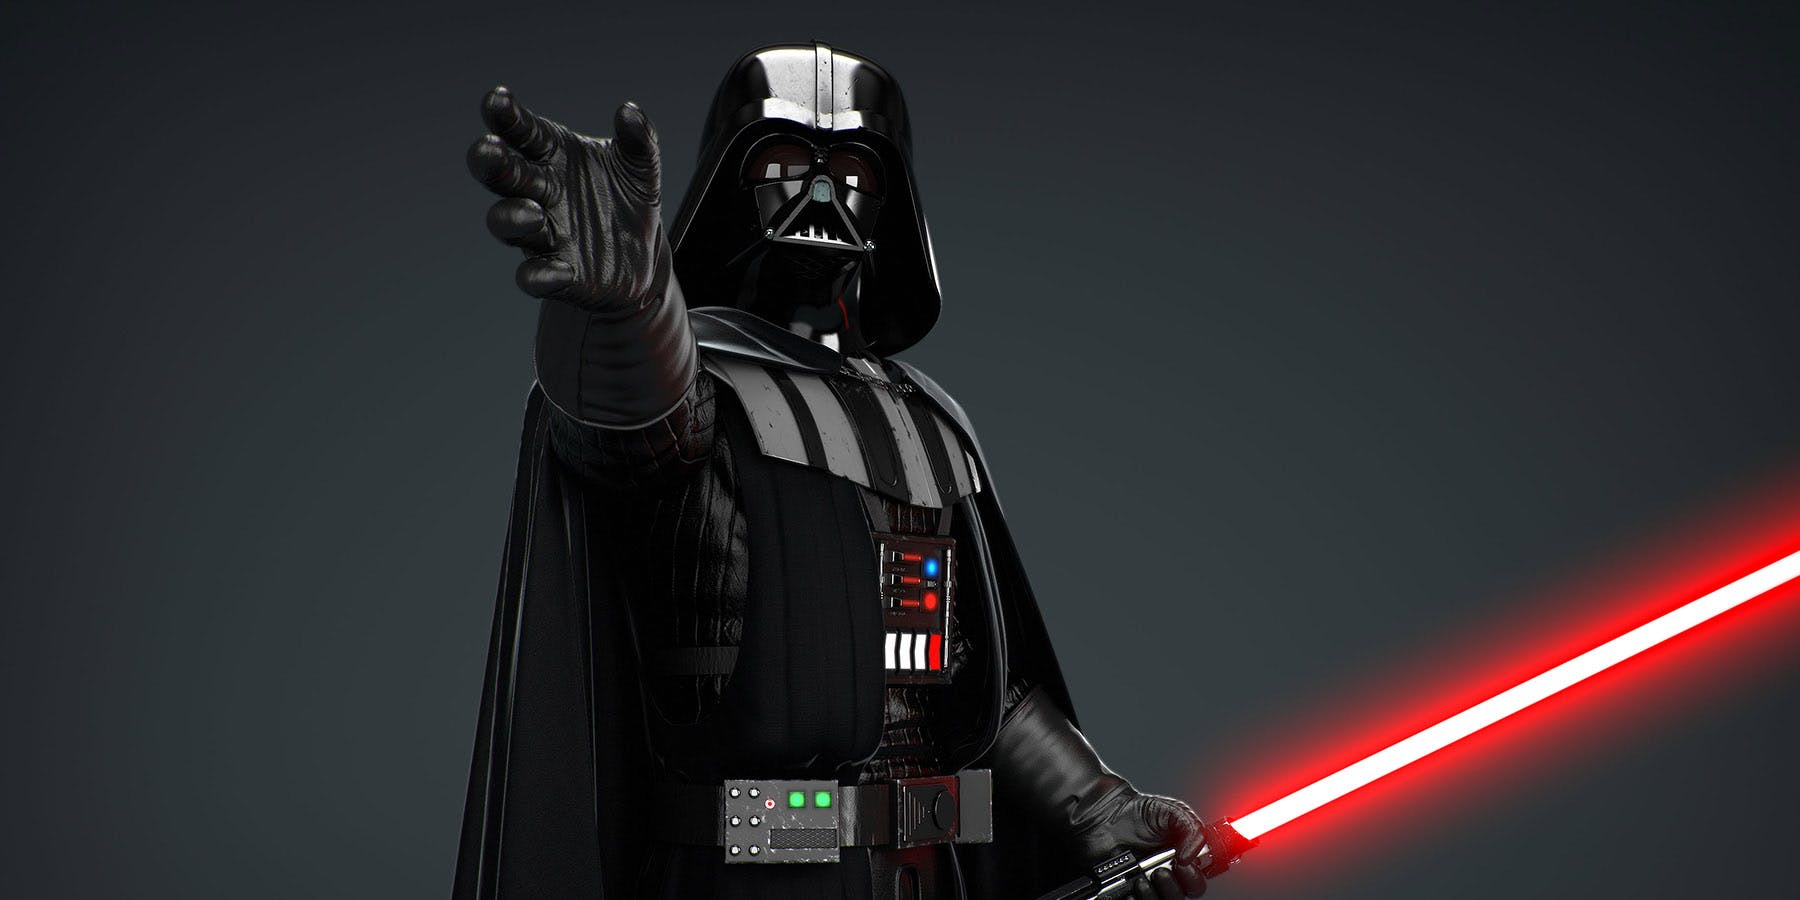

,follower_id,tweets,tweet_text,sentiment_score
74,135225426,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Sat Jun 20 13:27:32 +0000 2020', 'id': 1274333061606408192, 'id_str': '1274333061606408192', 'text': ""@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper c...","[@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper comes to mind., @DanceOfJesus1 https://t.co/vTU7cPSvbr, RT @Allisonisanerd: The movie villain The actual villain https://t.co/tER901cX25, RT @TheFinestCC: Check out the new @...",0.076360
75,4693615681,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Aug 12 15:59:22 +0000 2019', 'id': 1160943871620026368, 'id_str': '1160943871620026368', 'text': 'Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solu...","[Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solution for caulking w… https://t.co/fn2TR3pX1v, Get the best #pool tile and #groutrepair services to restore your surfaces just like new. D’Sapone experts use pate… https://t.co/xu0...",0.227545
76,839166351520325633,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Jan 07 01:20:04 +0000 2019', 'id': 1082084418888630274, 'id_str': '1082084418888630274', 'text': 'Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a f...","[Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a fun wild side too.… https://t.co/GWbb2AwNdr, When you decide to not let something slide you pave a way for the women after you to follow in your footsteps. 👣💪🏿C… https://t.co/4ODxF...",0.358635
77,838444866883452929,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Oct 22 01:57:29 +0000 2019', 'id': 1186461541425655809, 'id_str': '1186461541425655809', 'text': 'RT @DamianAbella13: Muerde? No ! Pero te juzga ...",[RT @DamianAbella13: Muerde? No ! Pero te juzga https://t.co/MJSewmWnSp],-0.359500
78,976724939184144384,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Aug 13 11:31:31 +0000 2019', 'id': 1161238849424625664, 'id_str': '1161238849424625664', 'text': '@8T3 With Idencard app we redefined the traditional paper business card to become a smart and di...","[@8T3 With Idencard app we redefined the traditional paper business card to become a smart and digital business card… https://t.co/j5rmDf5Uv6, Hello folks! Here's a complete guide to creating your own digital business card using @IdencardApp \n\n#digitization… https://t.co/tD...",0.272890


In [6]:
darth_path = "/Users/mathewbuck/Desktop/dighum100/project/darth.jpg"
display(Image(darth_path, width=600, unconfined=True))
analyser = SentimentIntensityAnalyzer()

def sentiment_score(tweet_str):
    """parameter: string representing the text of a single tweet
       return: the sentiment rating of sentence_str"""
    return analyser.polarity_scores(tweet_str)["compound"]
    
    
def mean_sentiment(tweet_text_ser):
    return pd.Series([sentiment_score(tweet_text) for tweet_text in tweet_text_ser]).mean()
    
dataset_df["sentiment_score"] = dataset_df["tweet_text"].apply(mean_sentiment)
dataset_df = dataset_df[dataset_df['sentiment_score'].notnull()]
dataset_df.tail()

In [7]:
# This cell saves the DataFrame object I created above to text_df.csv in the project file.
dataset_df.to_csv("dataset_df.csv", sep=',', encoding='utf-8', index=False)  

In [10]:
# This cell reads in the text_df.csv file I created earlier to speed up processing.
dataset_df_path = "/Users/mathewbuck/Desktop/dighum100/project/dataset_df.csv"
dataset_df = pd.read_csv(dataset_df_path)
dataset_df.tail()

,follower_id,tweets,tweet_text,sentiment_score
72,135225426,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Sat Jun 20 13:27:32 +0000 2020', 'id': 1274333061606408192, 'id_str': '1274333061606408192', 'text': ""@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper c...","[""@PhilDav11305928 Might want to clean up your discord while you're at it. Cough cough , reaper comes to mind."", '@DanceOfJesus1 https://t.co/vTU7cPSvbr', 'RT @Allisonisanerd: The movie villain The actual villain https://t.co/tER901cX25', 'RT @TheFinestCC: Check out th...",0.076360
73,4693615681,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Aug 12 15:59:22 +0000 2019', 'id': 1160943871620026368, 'id_str': '1160943871620026368', 'text': 'Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solu...","['Trust D’Sapone for the best #shower #recaulking #services. Our new and patented alternative solution for caulking w… https://t.co/fn2TR3pX1v', 'Get the best #pool tile and #groutrepair services to restore your surfaces just like new. D’Sapone experts use pate… https://t.co/...",0.227545
74,839166351520325633,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Mon Jan 07 01:20:04 +0000 2019', 'id': 1082084418888630274, 'id_str': '1082084418888630274', 'text': 'Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a f...","['Like your aunt Sharron when she has one too many wine coolers, veggies can surprisingly have a fun wild side too.… https://t.co/GWbb2AwNdr', 'When you decide to not let something slide you pave a way for the women after you to follow in your footsteps. 👣💪🏿C… https://t.co/4O...",0.358635
75,838444866883452929,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Oct 22 01:57:29 +0000 2019', 'id': 1186461541425655809, 'id_str': '1186461541425655809', 'text': 'RT @DamianAbella13: Muerde? No ! Pero te juzga ...",['RT @DamianAbella13: Muerde? No ! Pero te juzga https://t.co/MJSewmWnSp'],-0.359500
76,976724939184144384,"[Status(_api=<tweepy.api.API object at 0x7f9d4d5694e0>, _json={'created_at': 'Tue Aug 13 11:31:31 +0000 2019', 'id': 1161238849424625664, 'id_str': '1161238849424625664', 'text': '@8T3 With Idencard app we redefined the traditional paper business card to become a smart and di...","['@8T3 With Idencard app we redefined the traditional paper business card to become a smart and digital business card… https://t.co/j5rmDf5Uv6', ""Hello folks! Here's a complete guide to creating your own digital business card using @IdencardApp \n\n#digitization… https://t.co...",0.272890


## Conclusions / Statistics

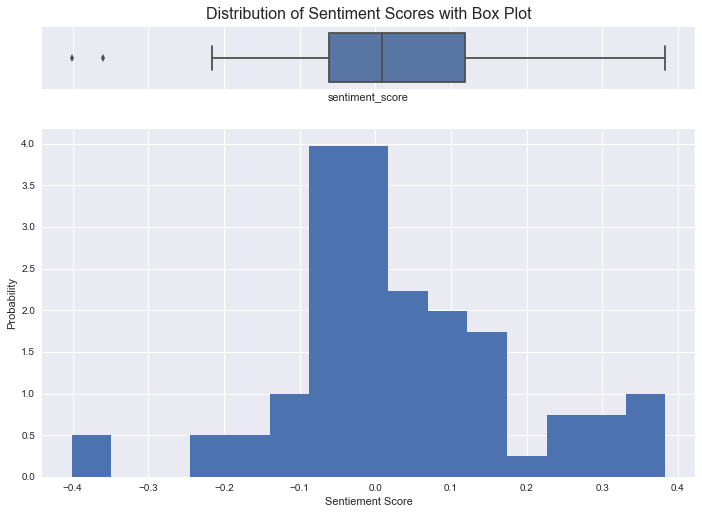

count    77.000000
mean      0.029699
std       0.151306
min      -0.401310
25%      -0.061755
50%       0.008884
75%       0.118100
max       0.383415
Name: sentiment_score, dtype: float64

In [26]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)

# Add a graph in each part
fig = sns.boxplot(dataset_df["sentiment_score"], ax=ax_box)
plt.hist(dataset_df["sentiment_score"], density=True, bins=15)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Sentiement Score');

# Change figure size
fig = sns.set(rc={'figure.figsize':(11.7, 8.27)}) 

# Move title up on y axis
plt.title("Distribution of Sentiment Scores with Box Plot", y=1.3, fontsize = 16);
plt.show()

dataset_df["sentiment_score"].describe()

## The Twitter Bot

In [ ]:
bot_path = "/Users/mathewbuck/Desktop/dighum100/project/twitter_bot.png"
display(Image(bot_path, width=600, unconfined=True))

# make initial request for most recent tweets (200 is the maximum allowed count)
# currently set up for 20 tweets total

lemon_tweets = api.user_timeline("donlemon", count=3)
lemon_tweet_ids = [tweet.id for tweet in lemon_tweets]

cuomo_tweets = api.user_timeline("ChrisCuomo", count=3)
cuomo_tweet_ids = [tweet.id for tweet in cuomo_tweets]

maddow_tweets = api.user_timeline("maddow", count=3)
maddow_tweet_ids = [tweet.id for tweet in maddow_tweets]

cnn_tweets = api.user_timeline("cnnbrk", count=3)
cnn_tweet_ids = [tweet.id for tweet in cnn_tweets]

msnbc_tweets = api.user_timeline("MSNBC_Breaking", count=3)
msnbc_tweet_ids = [tweet.id for tweet in msnbc_tweets]

biden_tweets = api.user_timeline("JoeBiden", count=3)
biden_tweet_ids = [tweet.id for tweet in biden_tweets]

yang_tweets = api.user_timeline("ZachandMattShow", count=2)
yang_tweet_ids = [tweet.id for tweet in yang_tweets]

mainstream_tweet_ids = (cuomo_tweet_ids + biden_tweet_ids + yang_tweet_ids 
                        + cnn_tweet_ids + msnbc_tweet_ids + maddow_tweet_ids + lemon_tweet_ids)
random.shuffle(mainstream_tweet_ids)


# twitter bot code ############################################################################################

num_follows = 0
num_tweets_made = 0

# catch 'You have already retweeted this Tweet.' errors 
for id in mainstream_tweet_ids:
    num_seconds = random.randint(5, 15)  #adjust time period between re-tweets 
    num_mins = num_seconds / 60
    # get the first x retweets for each mainstream tweet 
    first_100 = api.retweets(id, 100)
    
    # only retweet popular tweets
    if len(first_100) > 75:
        
        try:
            api.retweet(id)
            num_tweets_made += 1
            print()
            print("Number of tweets made: ", num_tweets_made)
           
        except tweepy.TweepError as e:
            print()
            print(e)
            
        #follow some sheep, some will follow back 
        potential_sheep = first_100[65 : 70]  # take 5 of the 100 sheep 
        potential_sheep_screen_names = [sheep.user.screen_name for sheep in potential_sheep]
        
        if len(potential_sheep_screen_names) > 0:
            for screen_name in potential_sheep_screen_names:
                
                try:
                    api.create_friendship(screen_name)  # follow some sheep who retweeted mainstream news 
                    num_follows += 1
                    num_seconds = random.randint(5, 15)  #adjust time period between re-tweets 
                    num_mins = num_seconds / 60
                    print("Number of follows: ", num_follows)
                    print("Minutes until next follow: ", num_mins)
                    time.sleep(num_seconds)
    
                except tweepy.TweepError as e:
                    print(e)
            
            